In [64]:
import sys
import nibabel as nib
from neuron.plot import slices
import numpy as np

In [65]:
flair_directory = '/data/ddmg/voxelmorph/data/3dflair/ADNI/'
!ls {flair_directory}

002_S_1261  018_S_2155	027_S_2245  035_S_4114	    067_S_4782	135_S_4723
002_S_4654  019_S_4293	027_S_4869  037_S_0377	    129_S_2332	141_S_1052
002_S_4799  019_S_4835	027_S_4919  037_S_0377.zip  129_S_4422	141_S_4160
007_S_2394  022_S_5004	032_S_4277  041_S_4143	    135_S_4356	941_S_4365
009_S_0751  027_S_2219	032_S_5289  067_S_4767	    135_S_4722


In [66]:
# find filenames
patient_id = '027_S_2245'

!ls '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32-adnisel/test/vols' | grep {patient_id}

ADNI_ADNI-3T-FS-5.3-Long_222935.long.027_S_2245_base_mri_talairach_norm.npz
ADNI_ADNI-3T-FS-5.3-Long_225374.long.027_S_2245_base_mri_talairach_norm.npz
ADNI_ADNI-3T-FS-5.3-Long_241368.long.027_S_2245_base_mri_talairach_norm.npz
ADNI_ADNI-3T-FS-5.3-Long_281891.long.027_S_2245_base_mri_talairach_norm.npz
ADNI_ADNI-3T-FS-5.3-Long_358196.long.027_S_2245_base_mri_talairach_norm.npz
ADNI_ADNI-3T-FS-5.3-Long_427971.long.027_S_2245_base_mri_talairach_norm.npz
ADNI_ADNI-3T-FS-5.3-Long_470409.long.027_S_2245_base_mri_talairach_norm.npz


In [69]:
!ls {flair_directory + patient_id + '/Sagittal_3D_FLAIR'}
!ls {flair_directory + patient_id + '/Sagittal_3D_FLAIR/2017-02-01_13_43_17.0/S532706'}


2017-02-01_13_43_17.0  2018-01-03_14_26_55.0
ADNI_027_S_2245_MR_Sagittal_3D_FLAIR__br_raw_20170202123216002_19_S532706_I814948.nii
ADNI_027_S_2245_MR_Sagittal_3D_FLAIR__br_raw_20170202123216002_19_S532706_I814948_robex.nii


In [70]:
t1_vols_directory = '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32-adnisel/test/vols/'
t1_segs_directory = '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32-adnisel/test/asegs/'

# once you find your filenames, set variables
t1_scan_id = '470409'

t1_vol_filename = t1_vols_directory + 'ADNI_ADNI-3T-FS-5.3-Long_470409.long.027_S_2245_base_mri_talairach_norm.npz'
t1_seg_filename = t1_segs_directory + 'ADNI_ADNI-3T-FS-5.3-Long_470409.long.027_S_2245_base_mri_talairach_aseg.npz'

t2_filename = flair_directory + patient_id + '/Sagittal_3D_FLAIR/2017-02-01_13_43_17.0/S532706/ADNI_027_S_2245_MR_Sagittal_3D_FLAIR__br_raw_20170202123216002_19_S532706_I814948_robex.nii'
t2_new_filename = '../t2_' + patient_id + '_2017.nii' # might need to change

# no need to change below
t1_new_vol_filename = '../t1_' + patient_id + '_' + t1_scan_id + '.nii'
t1_new_seg_filename = '../t1_' + patient_id + '_' + t1_scan_id + '_seg.nii'
t1_new_vol_warped_filename = '../t1_' + patient_id + '_' + t1_scan_id + '_warped.nii'
t1_new_seg_warped_filename = '../t1_' + patient_id + '_' + t1_scan_id + '_seg_warped.nii'

t2_final_filename = '../t2_atlas_' + patient_id + '.nii'
t2_final_seg_filename = '../t2_atlas_seg_' + patient_id + '.nii'


In [71]:
print(t1_new_vol_filename)

../t1_027_S_2245_470409.nii


In [72]:
# convert t1 npzs to nii
v = np.load(t1_vol_filename)['vol_data']; 
nii = nib.Nifti1Image(v, np.eye(4)); 
nib.save(nii, t1_new_vol_filename);

v = np.load(t1_seg_filename)['vol_data']; 
nii = nib.Nifti1Image(v, np.eye(4)); 
nib.save(nii, t1_new_seg_filename);

In [73]:
# get t2 images to be in the correct orientation
t2 = nib.load(t2_filename).get_data()
t2 = np.flip(np.transpose(t2, (0, 2, 1)), axis=1)
t2 = np.flip(t2, axis=0)

nii = nib.Nifti1Image(t2, np.eye(4)); 
nib.save(nii, t2_new_filename);

In [74]:
# compute same-subject affine warping from t1 to t2
!/data/vision/polina/shared_software/ANTS/build/bin/ANTS 3 -m MI[{t2_new_filename},{t1_new_vol_filename},1,48] -o /home/courtney/voxelmorph/ants -i 0
# apply warping on t1 segmentation
!/data/vision/polina/shared_software/ANTS/build/bin/WarpImageMultiTransform 3 {t1_new_seg_filename} {t1_new_seg_warped_filename} -R {t2_new_filename} /home/courtney/voxelmorph/antsAffine.txt --use-NN
# apply warping on t1 vol, in case needed for debugging
!/data/vision/polina/shared_software/ANTS/build/bin/WarpImageMultiTransform 3 {t1_new_vol_filename} {t1_new_vol_warped_filename} -R {t2_new_filename} /home/courtney/voxelmorph/antsAffine.txt



 Run Reg 
 values 1
  Fixed image file: ../t2_027_S_2245_2017.nii
  Moving image file: ../t1_027_S_2245_470409.nii
Metric 0:  Not a Point-set
  Fixed image file: ../t2_027_S_2245_2017.nii
  Moving image file: ../t1_027_S_2245_470409.nii
  similarity metric weight: 1
  Radius: [48, 48, 48]
  radius: [48, 48, 48]
Use identity affine transform as initial affine para.
aff_init.IsNull()==1
Use identity affine transform as initial fixed affine para.
fixed_aff_init.IsNull()==1
Continue affine registration from the input
affine_opt.use_rotation_header = 0
affine_opt.ignore_void_orgin = 0
transform_initial: IsNotNull():0
OptAffine: metric_type=AffineWithMutualInformation
MI_bins=32 MI_samples=32000
number_of_seeds=0 time_seed=1550772607
number_of_levels=3
number_of_iteration_list=[10000,10000,10000]
graident_scales=[1,1,1,1,1,1,1,1,1,1,0.0001,0.0001,0.0001]
is_rigid = 0
mask null: 1
maximum_step_length=0.1
relaxation_factor=0.5
minimum_step_length=0.0001
translation_scales=0.0001
opt.transform_

In [75]:
# compute affine warping from t2 to t1 atlas
!/data/vision/polina/shared_software/ANTS/build/bin/ANTS 3 -m MI[../t1_atlas.nii,{t2_new_filename},1,48] -o /home/courtney/voxelmorph/ants -i 0
# warp seg
!/data/vision/polina/shared_software/ANTS/build/bin/WarpImageMultiTransform 3 {t1_new_seg_warped_filename} {t2_final_seg_filename} -R ../t1_atlas.nii /home/courtney/voxelmorph/antsAffine.txt --use-NN
# warp vol
!/data/vision/polina/shared_software/ANTS/build/bin/WarpImageMultiTransform 3 {t2_new_filename} {t2_final_filename} -R ../t1_atlas.nii /home/courtney/voxelmorph/antsAffine.txt


 Run Reg 
 values 1
  Fixed image file: ../t1_atlas.nii
  Moving image file: ../t2_027_S_2245_2017.nii
Metric 0:  Not a Point-set
  Fixed image file: ../t1_atlas.nii
  Moving image file: ../t2_027_S_2245_2017.nii
  similarity metric weight: 1
  Radius: [48, 48, 48]
  radius: [48, 48, 48]
Use identity affine transform as initial affine para.
aff_init.IsNull()==1
Use identity affine transform as initial fixed affine para.
fixed_aff_init.IsNull()==1
Continue affine registration from the input
affine_opt.use_rotation_header = 0
affine_opt.ignore_void_orgin = 0
transform_initial: IsNotNull():0
OptAffine: metric_type=AffineWithMutualInformation
MI_bins=32 MI_samples=32000
number_of_seeds=0 time_seed=1550772657
number_of_levels=3
number_of_iteration_list=[10000,10000,10000]
graident_scales=[1,1,1,1,1,1,1,1,1,1,0.0001,0.0001,0.0001]
is_rigid = 0
mask null: 1
maximum_step_length=0.1
relaxation_factor=0.5
minimum_step_length=0.0001
translation_scales=0.0001
opt.transform_initial.IsNull(): 1
 opt

In [ ]:
print(patient_id)
t2_atlas = nib.load(t2_final_filename).get_data() # this gives you a LxWxH volume
t2_seg = nib.load(t2_final_seg_filename).get_data()
t1_atlas = nib.load('../t1_atlas.nii').get_data()

slices([t2_atlas[80, :, :], t2_atlas[:, 90, :], t2_atlas[:, :, 90]])
# slices([t2_seg[80, :, :], t2_seg[:, 90, :], t2_seg[:, :, 90]])
slices([t1_atlas[80, :, :], t1_atlas[:, 90, :], t1_atlas[:, :, 90]])

141_S_1052


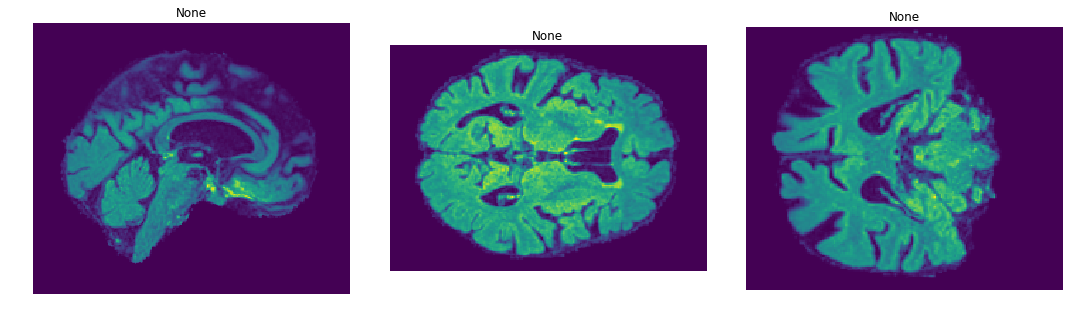

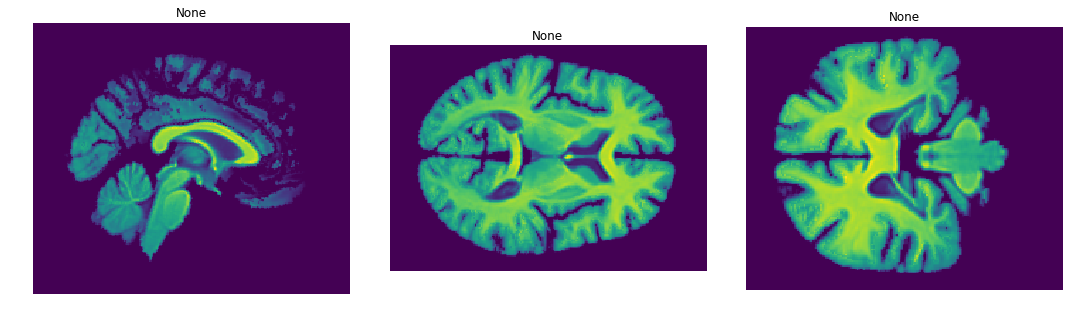

(<matplotlib.figure.Figure at 0x7faee299f588>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faee36d4ac8>,
       dtype=object))

In [63]:
print('141_S_1052')
t2_atlas = nib.load('../t2_atlas_warped.nii').get_data() # this gives you a LxWxH volume
# t2_seg = nib.load(t2_final_seg_filename).get_data()
t1_atlas = nib.load('../t1_atlas.nii').get_data()

slices([t2_atlas[80, :, :], t2_atlas[:, 90, :], t2_atlas[:, :, 90]])
# slices([t2_seg[80, :, :], t2_seg[:, 90, :], t2_seg[:, :, 90]])
slices([t1_atlas[80, :, :], t1_atlas[:, 90, :], t1_atlas[:, :, 90]])

027_S_2219


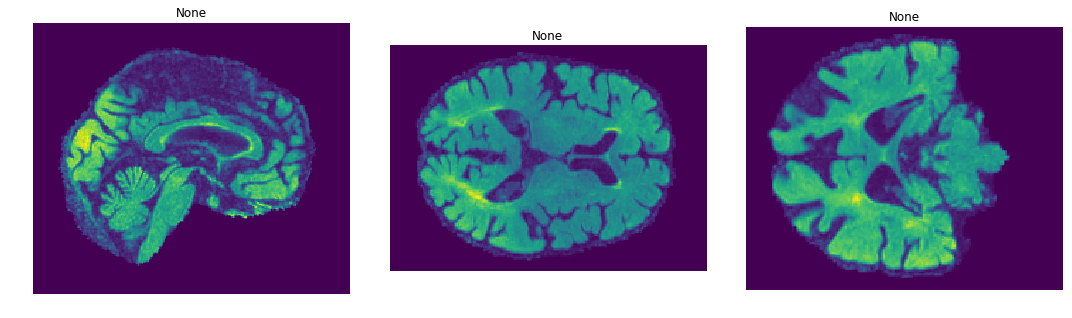

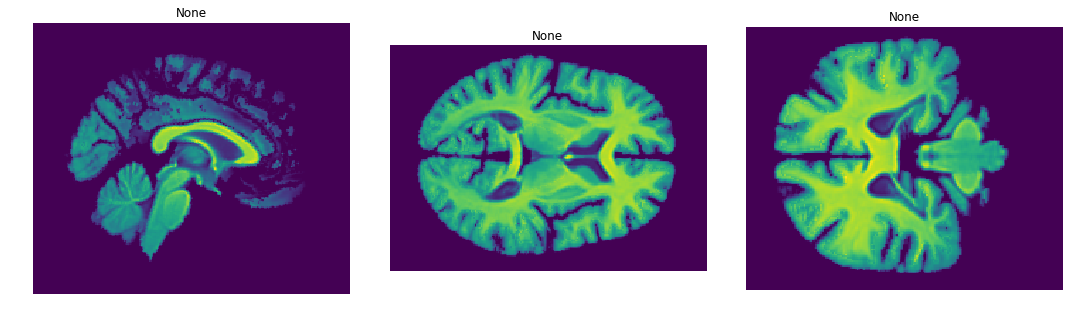

(<matplotlib.figure.Figure at 0x7faee28452e8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faee39ca470>,
       dtype=object))

In [61]:
print(patient_id)
t2_atlas = nib.load(t2_final_filename).get_data() # this gives you a LxWxH volume
t2_seg = nib.load(t2_final_seg_filename).get_data()
t1_atlas = nib.load('../t1_atlas.nii').get_data()

slices([t2_atlas[80, :, :], t2_atlas[:, 90, :], t2_atlas[:, :, 90]])
# slices([t2_seg[80, :, :], t2_seg[:, 90, :], t2_seg[:, :, 90]])
slices([t1_atlas[80, :, :], t1_atlas[:, 90, :], t1_atlas[:, :, 90]])

019_S_4293


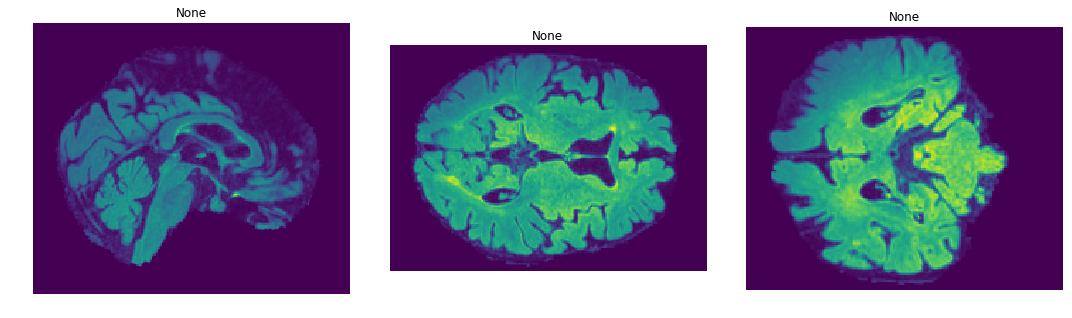

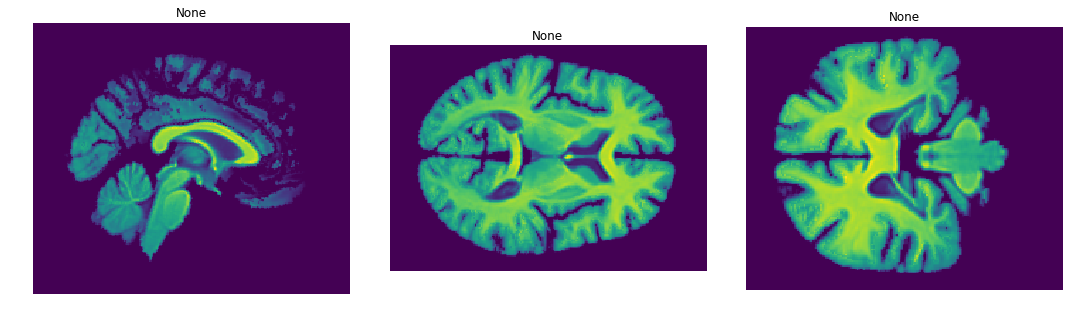

(<matplotlib.figure.Figure at 0x7faeda4bf588>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faee386e128>,
       dtype=object))

In [47]:
print(patient_id)
t2_atlas = nib.load(t2_final_filename).get_data() # this gives you a LxWxH volume
t2_seg = nib.load(t2_final_seg_filename).get_data()
t1_atlas = nib.load('../t1_atlas.nii').get_data()

slices([t2_atlas[80, :, :], t2_atlas[:, 90, :], t2_atlas[:, :, 90]])
# slices([t2_seg[80, :, :], t2_seg[:, 90, :], t2_seg[:, :, 90]])
slices([t1_atlas[80, :, :], t1_atlas[:, 90, :], t1_atlas[:, :, 90]])

018_S_2155


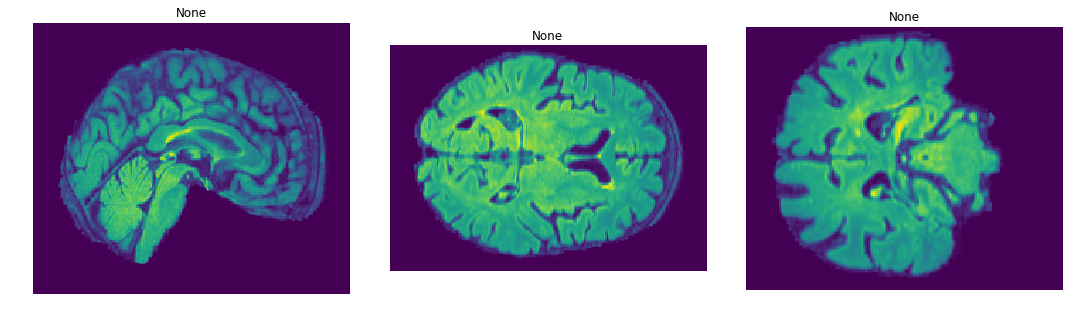

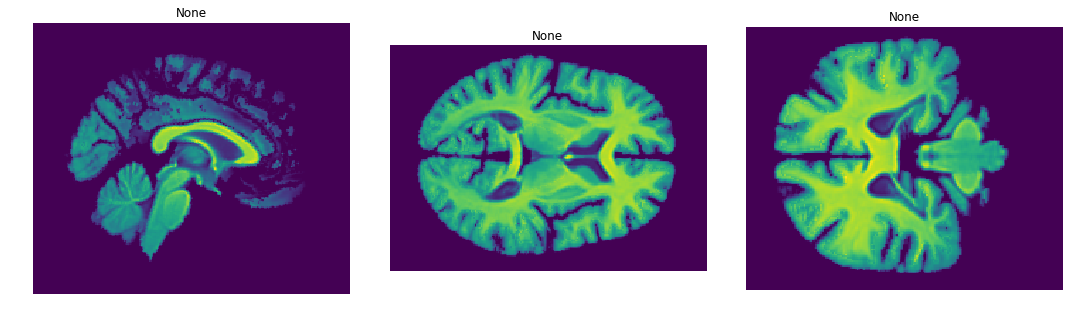

(<matplotlib.figure.Figure at 0x7faee28a4390>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faee3139a58>,
       dtype=object))

In [36]:
print(patient_id)
t2_atlas = nib.load(t2_final_filename).get_data() # this gives you a LxWxH volume
t2_seg = nib.load(t2_final_seg_filename).get_data()
t1_atlas = nib.load('../t1_atlas.nii').get_data()

slices([t2_atlas[80, :, :], t2_atlas[:, 90, :], t2_atlas[:, :, 90]])
# slices([t2_seg[80, :, :], t2_seg[:, 90, :], t2_seg[:, :, 90]])
slices([t1_atlas[80, :, :], t1_atlas[:, 90, :], t1_atlas[:, :, 90]])

009_S_0751


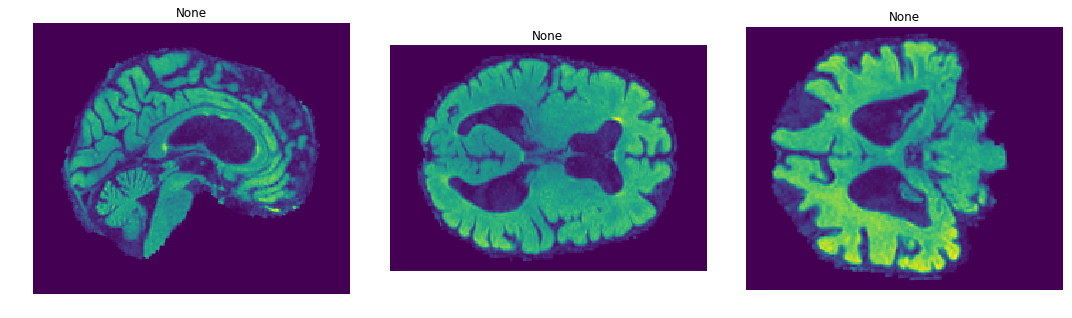

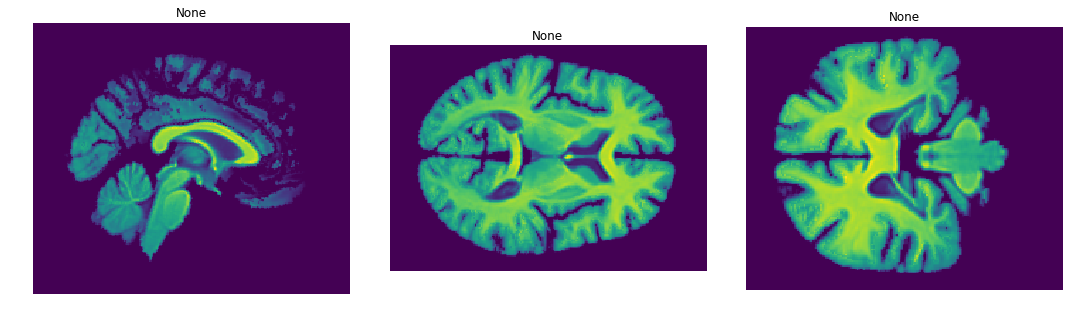

(<matplotlib.figure.Figure at 0x7faee29b9e10>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faee2814cf8>,
       dtype=object))

In [25]:
print(patient_id)
t2_atlas = nib.load(t2_final_filename).get_data() # this gives you a LxWxH volume
t2_seg = nib.load(t2_final_seg_filename).get_data()
t1_atlas = nib.load('../t1_atlas.nii').get_data()

slices([t2_atlas[80, :, :], t2_atlas[:, 90, :], t2_atlas[:, :, 90]])
# slices([t2_seg[80, :, :], t2_seg[:, 90, :], t2_seg[:, :, 90]])
slices([t1_atlas[80, :, :], t1_atlas[:, 90, :], t1_atlas[:, :, 90]])

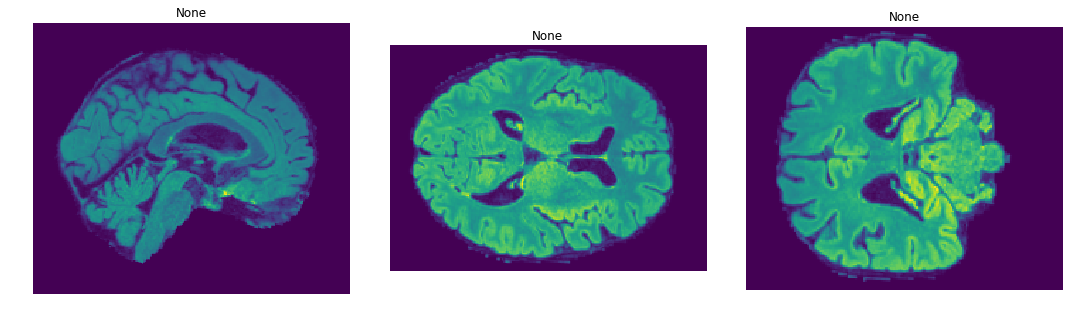

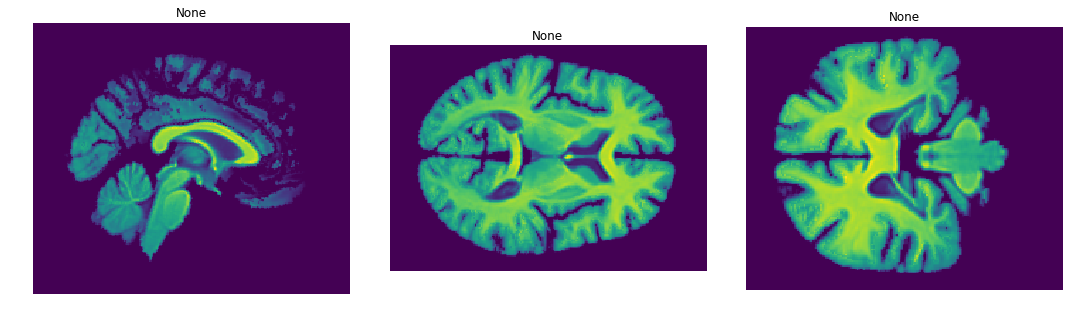

(<matplotlib.figure.Figure at 0x7faee3ced7b8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faee3a86358>,
       dtype=object))

In [13]:
print(patient_id)
t2_atlas = nib.load(t2_final_filename).get_data() # this gives you a LxWxH volume
t2_seg = nib.load(t2_final_seg_filename).get_data()
t1_atlas = nib.load('../t1_atlas.nii').get_data()

slices([t2_atlas[80, :, :], t2_atlas[:, 90, :], t2_atlas[:, :, 90]])
# slices([t2_seg[80, :, :], t2_seg[:, 90, :], t2_seg[:, :, 90]])
slices([t1_atlas[80, :, :], t1_atlas[:, 90, :], t1_atlas[:, :, 90]])